In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from scipy.signal import butter, freqz, filtfilt, firwin, iirnotch, lfilter
from data_extract_iphone import pull_data, pull_orientation_data
import os
import sys
import csv
import numpy as np
from sklearn import model_selection, metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from features import extract_features
from util import slidingWindow, reset_vars
import pickle
import scipy
from scipy.signal import find_peaks, argrelmin
from matplotlib import collections  as mc

accel_file = 'data'
data = np.genfromtxt("demo.csv", delimiter=',',skip_header=1)
qx, qy, qz, qw, yaw, roll, pitch, timestamps = pull_orientation_data(accel_file, 'demo')

c = timestamps[0]
timestamps = (timestamps - c)/1000000000

In [2]:
loaded_model = pickle.load(open("classifier.pickle", 'rb'))
print("Reorienting accelerometer data...")
sys.stdout.flush()
reset_vars()

# %%---------------------------------------------------------------------------
#
#		                Extract Features & Labels
#
# -----------------------------------------------------------------------------

window_size = 20
step_size = 20

print("Extracting features and labels for window size {} and step size {}...".format(window_size, step_size))
sys.stdout.flush()

X = []
Y = []

for i,window_with_timestamp_and_label in slidingWindow(data, window_size, step_size):
    window = window_with_timestamp_and_label[:,2:] 
    feature_names, x = extract_features(window)
    X.append(x)
predictions = loaded_model.predict(X)

predictions = np.repeat(predictions,21, axis=0)
reader = csv.reader(open('demo.csv', 'r'))
writer = csv.writer(open('output.csv', 'w'))

i=0
for row in reader:
    row.append(predictions[i])
    i+=1
    writer.writerow(row)


Reorienting accelerometer data...
Extracting features and labels for window size 20 and step size 20...
/Users/yassmenmekky/cs328/final-tyk/features.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  return [max(np.fft.rfft(magnitude).astype(float))]


In [3]:
color = []
f = open('output.csv')
f.readline()
for line in f:
    value = line.split(',')
    color.append(float(value[-1]))

magnitude = []
for i in range(len(qx)):
    magnitude.append((qx[i]**2+qy[i]**2+qx[i]**2+qz[i]**2)**(1/2))

#Butterworth filter
order = 5
fs = 50.0  
cutoff = 0.5

nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='low', analog=False)

magnitude = filtfilt(b, a, magnitude)

peaks = find_peaks(magnitude,prominence=0.01)

coordinatesX, coordinatesY = [],[]
coordinatesX = peaks[0]

for i in range(0,len(peaks[0])):
    coordinatesY.append(magnitude[peaks[0][i]])


crunches: 10 reps
planks: 1 reps
bicycle crunches: 13 reps
mountain climbers: 9 reps


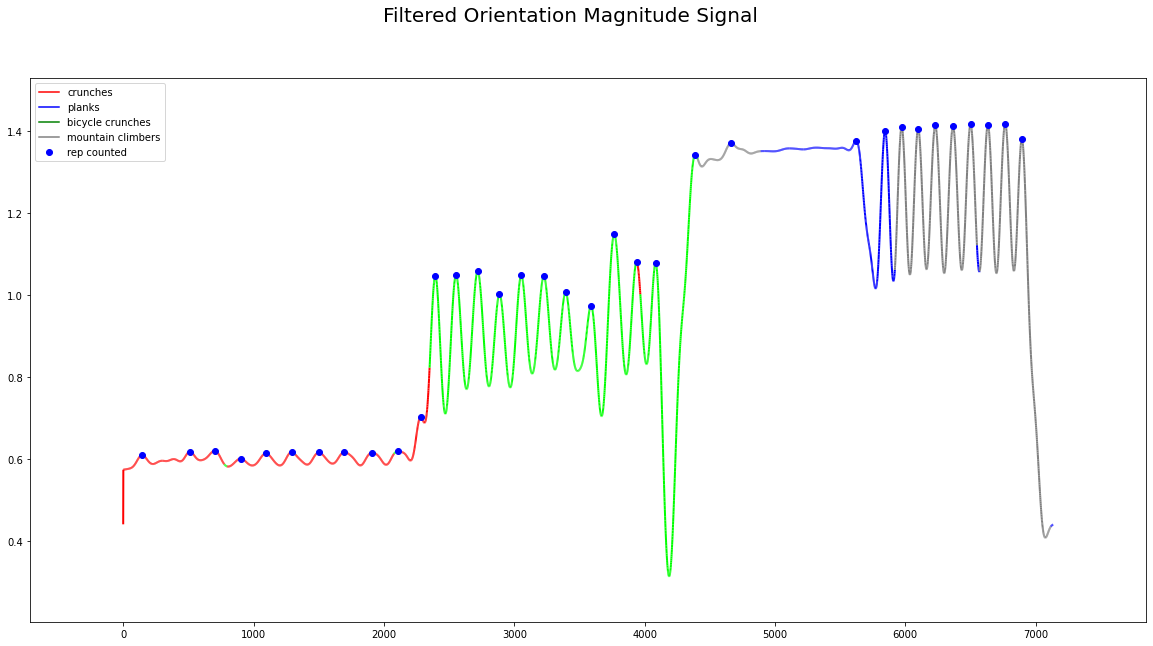

In [4]:

crunchesX, crunchesY = [], []
planksX, planksY = [], []
bicrunchesX, bicrunchesY = [], []
mclimbersX, mclimbersY = [], []
lines = []
colors = []
reps = [0,0,0,0]
plankCount = 0
plankReps = []

for i in range(len(color)):
    if i >= len(color):
        print(i)
    if(i in peaks[0]):
        reps[int(color[i]-1)] +=1
    if(color[i] == 1):
        lines.append([(i,magnitude[i]), ((i-1,magnitude[i-1]))])
        colors.append([1,0,0])
        crunchesX.append(i)
        crunchesY.append(magnitude[i])
    if(color[i]==2): #planks
        plankCount+=1
        lines.append([(i,magnitude[i]), ((i-1,magnitude[i-1]))])
        colors.append([0,0,1])
        planksX.append(i)
        planksY.append(magnitude[i])
    elif(plankCount>0):
        plankReps.append(plankCount) 
        plankCount = 0
    if(color[i]==3):
        lines.append([(i,magnitude[i]), ((i-1,magnitude[i-1]))])
        colors.append([0,1,0])
        bicrunchesX.append(i)
        bicrunchesY.append(magnitude[i])
    if(color[i]==4):
        lines.append([(i,magnitude[i]), ((i-1,magnitude[i-1]))])
        colors.append([0.5,0.5,0.5])
        mclimbersX.append(i)
        mclimbersY.append(magnitude[i])

reps[1] = int(reps[1]/2)
exercises = ['crunches', 'planks', 'bicycle crunches', 'mountain climbers']

for i in range(4):
    print("%s: %d reps" % (exercises[i], reps[i]))

lc = mc.LineCollection(lines, colors=colors, linewidths=2)
fig, ax = pl.subplots(figsize=(20,10))
fig.suptitle("Filtered Orientation Magnitude Signal", fontsize=20)
ax.plot([],[], color='r', label='crunches')
ax.plot([],[], color='b', label='planks')
ax.plot([],[], color='g', label='bicycle crunches')
ax.plot([],[], color='gray', label='mountain climbers')
ax.plot(coordinatesX, coordinatesY, 'bo',label='rep counted')
ax.legend(loc="upper left")
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)

#red - crunches blue - planks green - bicycle crunches gray - mountain climbers